# Modelo de BETO (BERT en español)

Este modelo se basa en la paquetería de transformers de hugging face (https://pypi.org/project/transformers/) que se enfoca en la implementación de modelos de transformer.

El modelo pre-entrenado de BETo puede consultarse en https://github.com/dccuchile/beto

In [1]:
import torch
from transformers import BertForMaskedLM, BertTokenizer

tokenizer = BertTokenizer.from_pretrained("pytorch/", do_lower_case=False)
model = BertForMaskedLM.from_pretrained("pytorch/")

Some weights of the model checkpoint at pytorch/ were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at pytorch/ and are newly initialized: ['cls.predictions.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Modelo

El modelo, como BERT, consiste en un encoder de transformer. Más información sobre el modelo puede encontrarse en el artículo original: https://users.dcc.uchile.cl/~jperez/papers/pml4dc2020.pdf

In [2]:
print(model)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

# Modelos del lenguaje enmascarados

En este tipo de modelos se puede predecir una palabra "enmascarada" que se encuentra en un contexto específico. Así dada una cadena:

$$w_1, w_2,..., [MASK],..., w_T$$

El modelo puede predecir la palabra ausente $[MASK]$ dado el contexto:

In [5]:
text = "[CLS] Cuando yo [MASK] al [MASK], entonces la fábrica comenzó a [MASK] [SEP]"

#Se obtienen los tokens del texto
tokens = tokenizer.tokenize(text)

#Indexa los tokens y guarda los que están enmascarados
masked_indxs = tuple(i for i,w in enumerate(tokens) if w=='[MASK]')

#Convierte los tokens en índices
indexed_tokens = tokenizer.convert_tokens_to_ids(tokens)
#Convierte los tokens en un tensor
tokens_tensor = torch.tensor([indexed_tokens])

#Aplica el modelo
predictions = model(tokens_tensor)[0]

print(model(tokens_tensor)[0].shape)

for i,mask_idx in enumerate(masked_indxs):
    #Ordena las predicciones de la más probable a la menos
    idxs = torch.argsort(predictions[0,mask_idx], descending=True)
    #Convierte los índices en palabras o subwords
    predicted_token = tokenizer.convert_ids_to_tokens(idxs)[:5]
    print('MASK',i,':',predicted_token)

torch.Size([1, 14, 31002])
MASK 0 : ['llegué', 'fui', 'estaba', 'iba', 'llegó']
MASK 1 : ['trabajo', 'colegio', 'hospital', 'instituto', 'mercado']
MASK 2 : ['funcionar', 'crecer', 'trabajar', 'ser', 'construir']


### Embeddings

In [81]:
#Vocabulario
model_voc = dict(tokenizer.vocab)

print('Número de tipos:', len(model_voc.keys()))

#Embeddings
embs = model.bert.embeddings.word_embeddings.weight.data
pos = model.bert.embeddings.position_embeddings.weight.data

print(embs.shape)
print(pos.shape)

Número de tipos: 31002
torch.Size([31002, 768])
torch.Size([512, 768])


#### Visualización de los embeddings estáticos

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
#from sklearn.manifold import TSNE

In [83]:
#Funcion para plotear los datos con labels
def plot_words(Z,ids):
    #Reduce la dimensionalidad a 2
    Z = PCA(2).fit_transform(Z)
    
    #Plotea con la marcas (marker) y el color indicado (c)
    r=0
    plt.scatter(Z[:,0],Z[:,1], marker='o', c='blue')
    for label,x,y in zip(ids, Z[:,0], Z[:,1]):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1

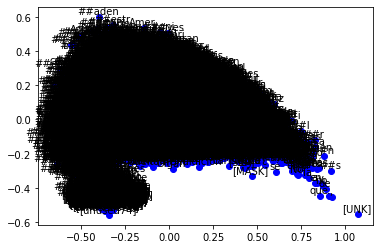

In [88]:
plot_words(embs, list(model_voc.keys()))
plt.show()